# Geospatial demand estimation

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Support:** [Ariane Millot](https://github.com/ariane-millot), [Martin J. Stringer]() & [Vignesh Shridharan](https://github.com/vignesh1987) <br />
**Funding:** Imperial College <br />

---------------------------


#### Brief overview

This notebook performs three main analytical processes:

- **Part 1**: Generated grid mesh (H3 hexagons) for the area of interest (given input admin boundary)
- **Part 2**: Extract GIS-based attributes (vecror or raster) to the grid
- **Part 3**: Build blocks estimating demand for the different energy vectors

A slightly more detailed description of the processing bits is presented before each part below. <br />


### Import necessary modules

In [1]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math

# System
import os
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

# Spatial
import geopandas as gpd
import json
import pyproj
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.wkt import dumps, loads
from shapely.ops import nearest_points
from pyproj import CRS
import ogr, gdal, osr
#import fiona


# Mapping / Plotting
from functools import reduce
#import datapane as dp 
#!datapane login --token="9bde41bfbc4ad14119e32086f9f06d2e5db1d5b8"
import folium
from folium.features import GeoJsonTooltip
from folium.plugins import BeautifyIcon
from folium.plugins import HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

%matplotlib inline

In [2]:
#import geopandas as gpd   # Note that you require geopandas version >= 0.7 that incluse clip see here for installation (https://gis.stackexchange.com/questions/360127/geopandas-0-6-1-installed-instead-of-0-7-0-in-conda-windows-10#)
import os
import fiona
import ipywidgets as widgets
from IPython.display import display
from rasterstats import zonal_stats
import rasterio
from geojson import Feature, Point, FeatureCollection
import rasterio.fill
from shapely.geometry import shape, mapping
import json
#from earthpy import clip    clip has been deprecated to geopandas
#import earthpy.spatial as es
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
import gdal
import datetime
import warnings
import pandas as pd
import scipy.spatial
warnings.filterwarnings('ignore')

#import contextily as ctx
import h3 as h3
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

''

### Define directories and dataset names

In [3]:
### Define directodies and dataset names

ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR + "\\" + 'Sample_Input'
out_path = ROOT_DIR + "\\" + 'Sample_Output'

## admininstrative boundary
admin_path = in_path + "\\"+ 'admin'
admin_name = "Copperbelt.gpkg"
adm_col_name = "ADM1_NAME"          ## Provide the name of the column you want to use to clip the hexagons e.g., "NAME" or "ADM1_NAME"

## mines layer
mines_path = in_path + "\\"+ 'mines'
mines_name = 'mines_zambia.gpkg'

In [4]:
## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32736")    # Projection system for the selected country -- see http://epsg.io/ for more info

### Import layers to be used

In [5]:
## admininstrative boundary
admin_gdf = gpd.read_file(admin_path + "\\" + admin_name)

## mines
mines = gpd.read_file(mines_path + "\\" + mines_name)

## Part 1. Create base grid with H3

### H3 - Hegagon - grid

In [6]:
# Make a copy of the original dataframe (as it might require some changes)
admin_gdf_copy_2 = admin_gdf.buffer(1.245)     ## this is ~15km --> 0.83*1.5

In [7]:
## No of multipolygons in the geometry
#check_geom_type = admin_gdf_copy.geometry.apply(lambda x: list(x))[0]

#len(check_geom_type)

It seems that the geometry is not a polygon but multipolygon. That is, the h3.polyfill will not work. In case the original layer consists of many parts then you shall follow a "merging" approach using a small buffer as described [here](https://gis.stackexchange.com/questions/311931/geopandas-equivalent-of-st-makepolygon/312004#312004). 

However, if polygons are not close this will not work. Thus, the following process (which I do only for one of them) needs to be done for each polygon separately -- unless you write some code to do this automatically! :)

In [8]:
#polygon = check_geom_type[0]
#polygon

In [9]:
#combined = [unary_union(polygon)]
#admin_gdf_copy.geometry = combined

In [10]:
# Convert this to geojson
gj = gpd.GeoSeries([admin_gdf_copy_2.geometry[0]]).__geo_interface__
geoJson = gj['features'][0]['geometry']

In [11]:
size = 7 ## resolution info here https://h3geo.org/docs/core-library/restable
hexagons = pd.DataFrame(h3.polyfill(geoJson, size), columns=['hexagons'])
hexagons.head()

,hexagons
0,873992a91ffffff
1,87346dd9bffffff
2,875530885ffffff
3,87346908cffffff
4,873996c21ffffff


In [12]:
hexagons['geometry'] = hexagons.hexagons.apply(lambda hex: Polygon(h3.h3_to_geo_boundary(hex)))
hexagons['centeroid'] = hexagons.hexagons.apply(lambda hex: h3.h3_to_geo(hex))

crs = {'init': 'epsg:4326'}

hexagons = gpd.GeoDataFrame(hexagons, crs=crs, geometry=hexagons.geometry)
hexagons['lon'] = hexagons['centeroid'].apply(lambda x: x[0])
hexagons['lat'] = hexagons['centeroid'].apply(lambda x: x[1])

hexagons = hexagons.drop(['centeroid'], axis=1)

display(hexagons.head())

,hexagons,geometry,lon,lat
0,873992a91ffffff,"POLYGON ((28.41584 -11.30441, 28.40593 -11.314...",28.403031,-11.300233
1,87346dd9bffffff,"POLYGON ((30.20258 -13.81674, 30.19239 -13.827...",30.189651,-13.812030
2,875530885ffffff,"POLYGON ((27.10893 -12.91537, 27.09887 -12.925...",27.096203,-12.910979
3,87346908cffffff,"POLYGON ((28.57683 -13.81992, 28.56665 -13.830...",28.563999,-13.815300
4,873996c21ffffff,"POLYGON ((29.09019 -12.94067, 29.08009 -12.951...",29.077324,-12.936172


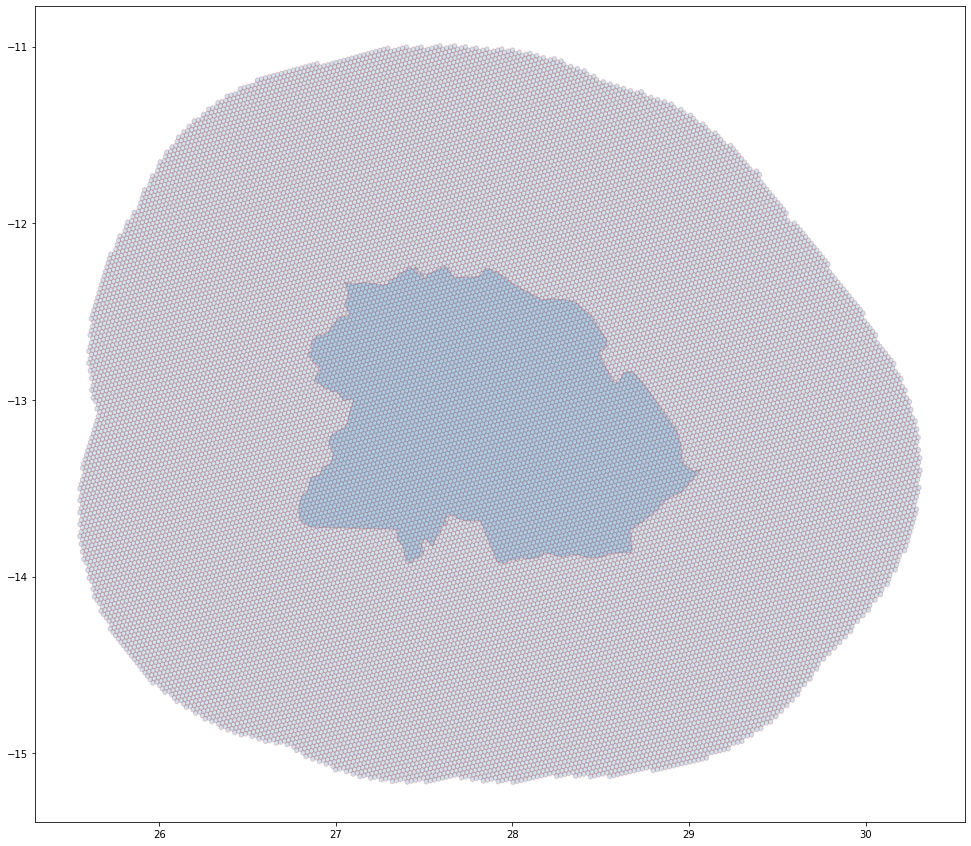

In [13]:
# Plot fishnet & basemap
fig, ax = plt.subplots(figsize=(25, 15))
hexagons.plot(ax=ax, edgecolor='brown', alpha=0.2)
admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)
ax.set_aspect('equal', 'box')

# Save plot as figure 
#plt.savefig('admin level basemap.png', bbox_inches='tight')

In [14]:
#Clipping to the borders of the admin area
join_left_df = gpd.sjoin(hexagons, admin_gdf[[adm_col_name, "geometry"]], how="left")
hexagons = join_left_df[join_left_df[adm_col_name].notnull()]

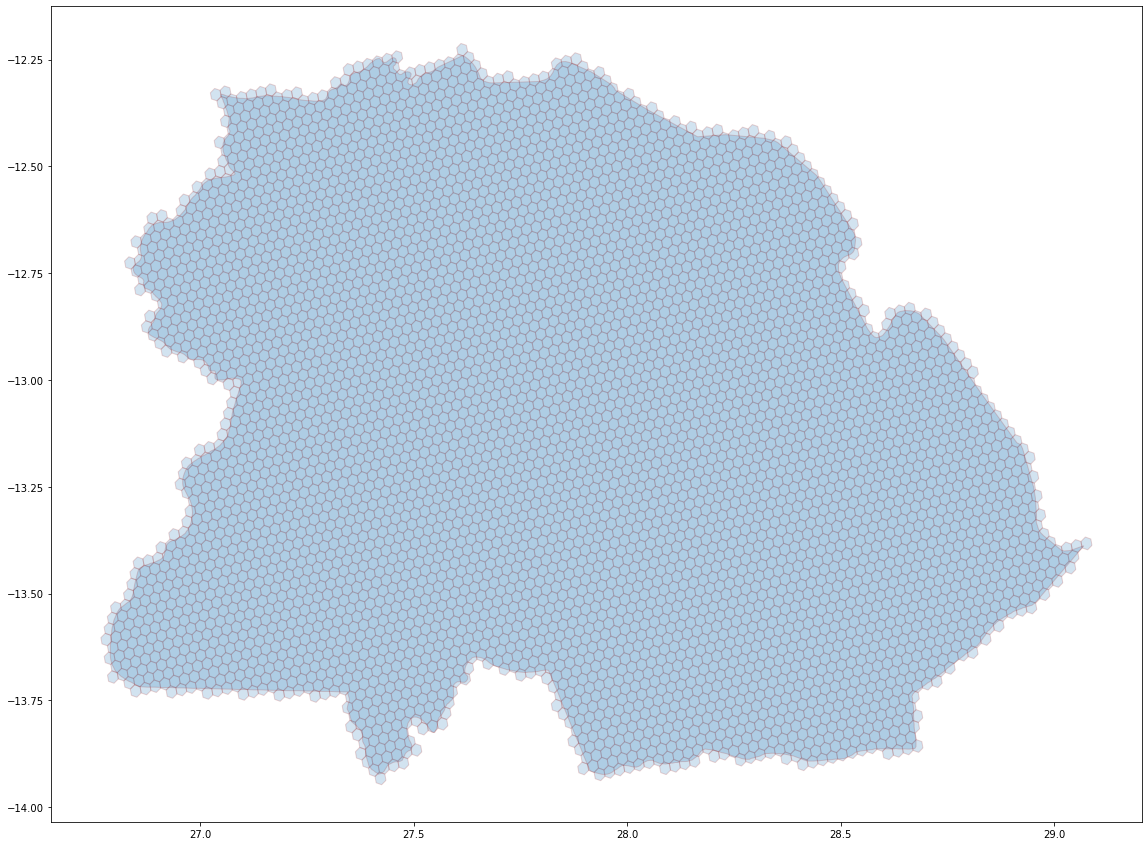

In [15]:
# Plot fishnet & basemap
fig, ax = plt.subplots(figsize=(25, 15))
hexagons.plot(ax=ax, edgecolor='brown', alpha=0.2)
admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)
ax.set_aspect('equal', 'box')

# Save plot as figure 
#plt.savefig('admin level basemap.png', bbox_inches='tight')

In [16]:
# Export dataframe to csv or gpkg
#hexagons.to_csv(out_path + "\\" + f'h3_grid_at_hex_{size}.csv', index=False)
hexagons.to_file(out_path + "\\" + f'h3_grid_at_hex_{size}.shp', index=False)

## Step 2. Extract GIS-based attributes

#### Select base map grid and proceed with processing

In [17]:
#hexagons = gpd.read_file(outpath + "\\" + "hex6_with_neighbors.geojson")

In [18]:
grid = hexagons

In [19]:
grid['id'] = range(1, len(grid)+1)

In [20]:
grid.head(3)

,hexagons,geometry,lon,lat,index_right,ADM1_NAME,id
2,875530885ffffff,"POLYGON ((27.10893 -12.91537, 27.09887 -12.925...",27.096203,-12.910979,0.0,COPPERBELT,1
3,87346908cffffff,"POLYGON ((28.57683 -13.81992, 28.56665 -13.830...",28.563999,-13.815300,0.0,COPPERBELT,2
6,875530c74ffffff,"POLYGON ((27.12596 -13.14014, 27.11587 -13.150...",27.113230,-13.135712,0.0,COPPERBELT,3


### Define extraction functions

In [21]:
def processing_raster(name, method, clusters):
    messagebox.showinfo('DemandMapping', 'Select the ' + name + ' map')
    raster=rasterio.open(filedialog.askopenfilename(filetypes = (("rasters","*.tif"),("all files","*.*"))))
    
    clusters = zonal_stats(
        clusters,
        raster.name,
        stats=[method],
        prefix=name, geojson_out=True, all_touched=True)
    
    print(datetime.datetime.now())
    return clusters

In [22]:
def finalizing_rasters(workspace, clusters, crs):
    output = workspace + r'\placeholder.geojson'
    with open(output, "w") as dst:
        collection = {
            "type": "FeatureCollection",
            "features": list(clusters)}
        dst.write(json.dumps(collection))
  
    clusters = gpd.read_file(output)
    os.remove(output)
    
    print(datetime.datetime.now())
    return clusters

In [32]:
def spatialjoinvectors(name, column, admin, crs, clusters):
    messagebox.showinfo('DemandMapping', 'Select the ' + name + ' map')
    # points=gpd.read_file(filedialog.askopenfilename(filetypes = (("shapefile","*.shp"),("all files","*.*"))))
    points=gpd.read_file(filedialog.askopenfilename(filetypes = (("all files","*.*"),)))
    points.head(5)
    
    points_clip = gpd.clip(points, admin)
    points_clip.crs = {'init' :'epsg:4326'}
    points_proj=points_clip.to_crs({ 'init': crs})
    points_proj[column] = points_proj[column].str.replace(',', '')
    points_proj[column] = points_proj[column].astype(float)     ## added so that the sample mining productions works; you may need to update this as per layer used
    
    gdf_points = points_proj[[column, "geometry"]]
    pointsInPolygon = gpd.sjoin(gdf_points, clusters, how="inner", op='within')
    group_by_name = pointsInPolygon[["id", column]].groupby(["id"]).sum().reset_index()
    clusters = pd.merge(clusters, group_by_name[['id', column]], on='id', how = 'left')
    
    return clusters

In [96]:
def spatialjoinvectorscsv(name, column, admin, crs, clusters):
    #admin = admin_gdf
    #crs = crs_WGS84
    #clusters = grid
    #column = "rwi"
    messagebox.showinfo('DemandMapping', 'Select the ' + + name + ' map')
    points=gpd.read_file(filedialog.askopenfilename(filetypes = (("all files","*.*"),)))
    points.head(5)

    points_clip = gpd.clip(points, admin)
    points_clip.crs = {'init' :'epsg:4326'}
    points_clip.head(5)
    points_proj=points_clip.to_crs({ 'init': crs})
    points_proj[column] = points_proj[column].str.replace(',', '')
    points_proj[column] = points_proj[column].astype(float)     ## added so that the sample mining productions works; you may need to update this as per layer used

    gdf_points = points_proj[[column, "geometry"]]
    pointsInPolygon = gpd.sjoin(gdf_points, clusters, how="inner", op='within')
    group_by_name = pointsInPolygon[["id", column]].groupby(["id"]).sum().reset_index()
    clusters = pd.merge(clusters, group_by_name[['id', column]], on='id', how = 'left')
    
    return clusters


In [97]:
clusters["rwi"].notna().describe()


KeyError: 'rwi'

## Extract raster values to hexagons

Extract count of buildings per hex

In [24]:
grid = processing_raster("buildings", "count", grid)      #Copperbelt_buildings_v2_0_count from https://apps.worldpop.org/peanutButter/

2023-03-20 23:27:35.391906


#### ..You can extract values from other raster layers here too..

##### Once done with rasters run this cell

In [25]:
grid = finalizing_rasters(out_path, grid, crs_proj)

2023-03-20 23:27:36.038944


In [26]:
grid.drop(['index_right'], axis=1, inplace=True)
grid.head(4)

,ADM1_NAME,hexagons,id,lat,lon,buildingscount,geometry
0,COPPERBELT,875530885ffffff,1,-12.910979,27.096203,1,"POLYGON ((27.10893 -12.91537, 27.09887 -12.925..."
1,COPPERBELT,87346908cffffff,2,-13.815300,28.563999,10,"POLYGON ((28.57683 -13.81992, 28.56665 -13.830..."
2,COPPERBELT,875530c74ffffff,3,-13.135712,27.113230,7,"POLYGON ((27.12596 -13.14014, 27.11587 -13.150..."
3,COPPERBELT,873469045ffffff,4,-13.515882,28.546440,71,"POLYGON ((28.55927 -13.52045, 28.54912 -13.530..."


## Extract information from vector layers

Extract sum production of mines in each cluster (hex)

In [33]:
## Run the extraction
#columnName = "Commodity Production - tonne (tonnes)"
columnName = 'Ore processed (tonnes)'
grid = spatialjoinvectors("Mines", columnName, admin_gdf, crs_WGS84, grid)

In [34]:
grid.head(4)

,ADM1_NAME,hexagons,id,lat,lon,buildingscount,geometry,Ore processed (tonnes)
0,COPPERBELT,875530885ffffff,1,-12.910979,27.096203,1,"POLYGON ((27.10893 -12.91537, 27.09887 -12.925...",NaN
1,COPPERBELT,87346908cffffff,2,-13.815300,28.563999,10,"POLYGON ((28.57683 -13.81992, 28.56665 -13.830...",NaN
2,COPPERBELT,875530c74ffffff,3,-13.135712,27.113230,7,"POLYGON ((27.12596 -13.14014, 27.11587 -13.150...",NaN
3,COPPERBELT,873469045ffffff,4,-13.515882,28.546440,71,"POLYGON ((28.55927 -13.52045, 28.54912 -13.530...",NaN


In [35]:
grid[columnName].sum()

24359691.0

# Step 3. Constructing Multi-vector Demand

### Industry

In [36]:
#Remove NA from ore production data
grid[columnName] = grid[columnName].fillna(0)

In [37]:
grid.head(3)

,ADM1_NAME,hexagons,id,lat,lon,buildingscount,geometry,Ore processed (tonnes)
0,COPPERBELT,875530885ffffff,1,-12.910979,27.096203,1,"POLYGON ((27.10893 -12.91537, 27.09887 -12.925...",0.0
1,COPPERBELT,87346908cffffff,2,-13.815300,28.563999,10,"POLYGON ((28.57683 -13.81992, 28.56665 -13.830...",0.0
2,COPPERBELT,875530c74ffffff,3,-13.135712,27.113230,7,"POLYGON ((27.12596 -13.14014, 27.11587 -13.150...",0.0


In [91]:
#Assess total energy consumption and total production
elec_nonFerrousMetals = 22897 #PJ
total_production = sum(grid[columnName])
print(total_production)
print("energy per tonne of ore:", elec_nonFerrousMetals/total_production*(10^6), "MJ/t")

24359691.0
energy per tonne of ore: 0.01127945342163823 MJ/t


In [49]:
#Allocate to each hexagon the industry energy consumption
grid["IndustryEnergy"]=grid[columnName]/total_production * elec_nonFerrousMetals
grid.head(3)

,ADM1_NAME,hexagons,id,lat,lon,buildingscount,geometry,Ore processed (tonnes),Residential,Commercial,TotalDem,IndustryEnergy
0,COPPERBELT,875530885ffffff,1,-12.910979,27.096203,1,"POLYGON ((27.10893 -12.91537, 27.09887 -12.925...",0.0,50,100,150.0,0.0
1,COPPERBELT,87346908cffffff,2,-13.815300,28.563999,10,"POLYGON ((28.57683 -13.81992, 28.56665 -13.830...",0.0,500,1000,1500.0,0.0
2,COPPERBELT,875530c74ffffff,3,-13.135712,27.113230,7,"POLYGON ((27.12596 -13.14014, 27.11587 -13.150...",0.0,350,700,1050.0,0.0


### Residential

In [86]:
elec_residential = 14481

In [99]:
# for each hexagon, determine if it's rural or urban --> to change!
grid["Location"] = grid.apply(lambda row: ("rural" if ((row['buildingscount'] < 100))
                                             else "urban"), axis=1)
# electrified or non-electrified status
grid["Status_electrified"] = grid.apply(lambda row: ("elec" if ((row['buildingscount'] < 100))
                                             else "nonelec"), axis=1)

In [106]:
# for each hexagon, assessment of the number of HH
shareResBuildings = {"urban": 0.60, "rural": 0.99}
sizeHH = {"urban": 5.1, "rural": 5.1}
grid["HH_number"]=grid["buildingscount"]*shareResBuildings[grid["Location"]]*sizeHH[grid["Location"]]

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [94]:
#Energy consumption from the MTF survey (load per region) (kWh/HH)
energyConsHH = 50 # dictionnary for each region one value

In [107]:
#for each hexagon, allocated the wri indicator
incomeIndex = 'rwi'
grid = spatialjoinvectorscsv("Wealth", incomeIndex, admin_gdf, crs_WGS84, grid)
averageRwi = 1 #compute the average of rwi

TypeError: bad operand type for unary +: 'str'

In [98]:
# Energy Consumption assessment
grid ["ResidentialEnergyCorrPerHH"] = grid['rwi']/averageRwi*energyConsHH["region"]
grid ["ResidentialEnergy"] = grid["HHnumber"]*grid ["ResidentialEnergyCorrPerHH"]*(0 if grid["Status_electrified"]="nonelec" else 1)

KeyError: 'rwi'

### Calculate Total Demand

**Demand = Residential + Commercial + Industrial (only an EXAMPLE)**

where, 

**Residential** = No of buildings X 50 kWh/building/year  

**Commercial**  = (No of buildings X 20 kWh/bld/year) if more than 100 buildings else (No of buildings X 100 kWh/bld/year)

**Industrial**  = Commodity Production - tonne (tonnes) from mines

In [65]:
grid["Residential"] = grid.apply(lambda row: (row['buildingscount']*50), axis=1)

In [67]:
grid["Commercial"] = grid.apply(lambda row: (row['buildingscount']*20 if ((row['buildingscount'] > 100))
                                             else row['buildingscount']*100), axis=1)

In [68]:
grid["TotalDem"] = grid.apply(lambda row: (row['Residential'] + 
                                          row['Commercial'] + 
                                          row["IndustryEnergy"]), axis=1)

In [69]:
grid.head(3)

,ADM1_NAME,hexagons,id,lat,lon,buildingscount,geometry,Ore processed (tonnes),Residential,Commercial,TotalDem,IndustryEnergy
0,COPPERBELT,875530885ffffff,1,-12.910979,27.096203,1,"POLYGON ((27.10893 -12.91537, 27.09887 -12.925...",0.0,50,100,150.0,0.0
1,COPPERBELT,87346908cffffff,2,-13.815300,28.563999,10,"POLYGON ((28.57683 -13.81992, 28.56665 -13.830...",0.0,500,1000,1500.0,0.0
2,COPPERBELT,875530c74ffffff,3,-13.135712,27.113230,7,"POLYGON ((27.12596 -13.14014, 27.11587 -13.150...",0.0,350,700,1050.0,0.0


In [70]:
grid.TotalDem.sum()

24527017.0

### Export result

In [71]:
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
grid = grid.to_crs({ 'init': crs_WGS84}) 

In [72]:
grid.to_file(out_path + "\\" + 'total_demand_grid.gpkg', driver="GPKG")
#grid.to_file(out_path + "\\" + 'total_demand_grid.geojson', driver="GeoJSON")

## Print maps for quick assessment

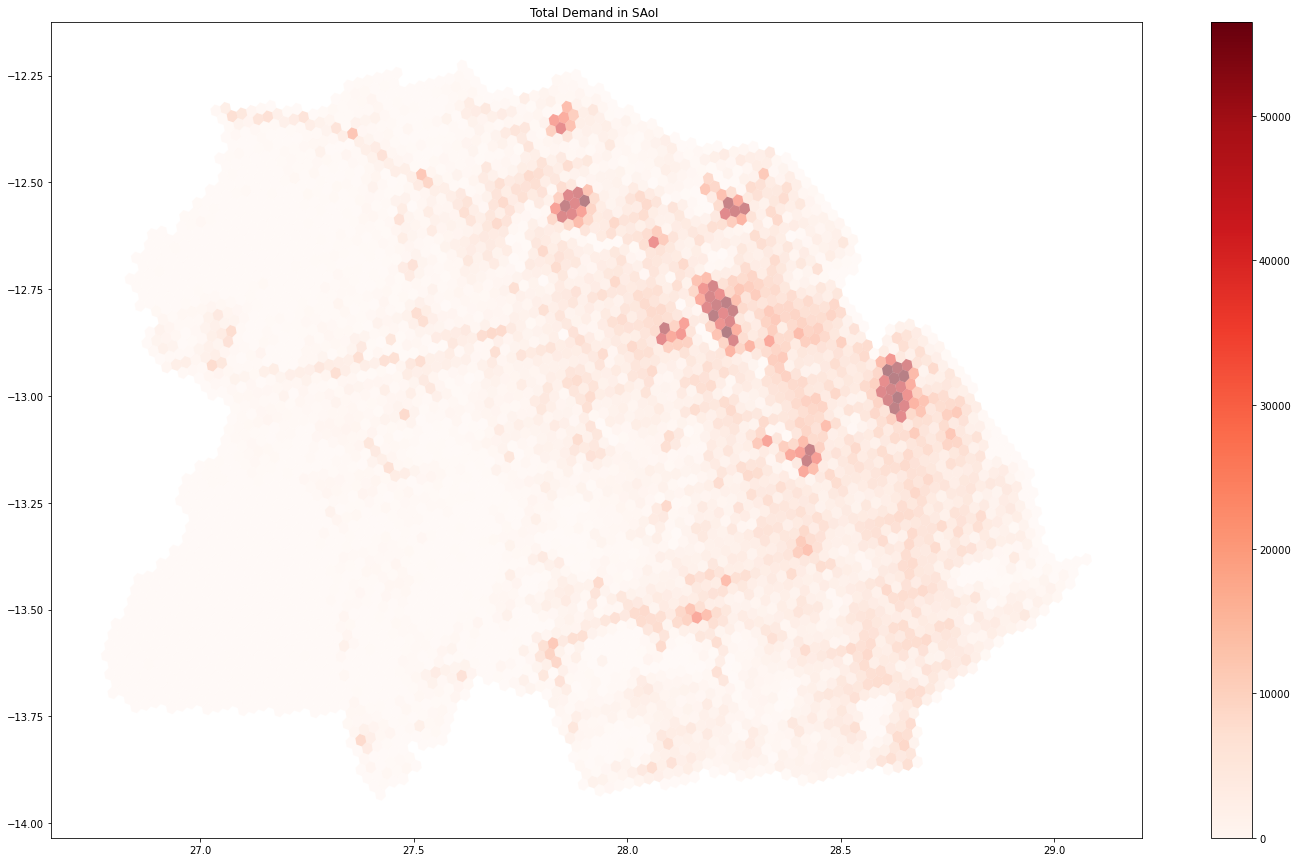

In [73]:
# Plotting for testinf
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot all crops
grid.sort_values('TotalDem', ascending=True).plot(
    ax=ax, column='TotalDem', cmap="Reds", legend=True, alpha=0.5)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Total Demand in {} '.format("SAoI"))

# Save plot as figure 
#plt.savefig('sample_priority_map.png', bbox_inches='tight')